# Extraction + Learning : Hardware Spec Sheets

This notebook demonstrates the full entity extraction process on transistor data sheets, extracting min storage temperatures.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# from snorkel import SnorkelSession
# session = SnorkelSession()

### Extraction

In [1]:
from snorkel.parser import HTMLParser
html_parser = HTMLParser(path='data/hardware/hardware_docs/')

In [2]:
from snorkel.parser import TableParser
table_parser = TableParser()

In [3]:
from snorkel.parser import CorpusParser
cp = CorpusParser(html_parser, table_parser, max_docs=200)
%time corpus = cp.parse_corpus(name='Hardware Corpus')

CPU times: user 58.8 s, sys: 1.12 s, total: 59.9 s
Wall time: 1min 28s


In [4]:
# session.add(corpus)
# session.commit()

In [5]:
# from snorkel.models import Corpus
# corpus = session.query(Corpus).filter(Corpus.name == 'CDR Corpus').one()
# corpus

In [80]:
from snorkel.candidates import TableNgrams
from snorkel.matchers import NumberMatcher, RangeMatcher

# Define a candidate space
ngrams = TableNgrams(n_max=3)

# Define a matcher
number_matcher = RangeMatcher(low=-70,high=-50)

In [81]:
# from snorkel.candidates import Candidates
# %time candidates = Candidates(ngrams, number_matcher, corpus.get_contexts())
# for c in candidates.get_candidates()[:5]: print c
    
from snorkel.candidates import CandidateExtractor
ce = CandidateExtractor(ngrams, number_matcher)
%time candidates = ce.extract(corpus.get_tables(), name='all')
for cand in candidates[:10]: 
    print cand
print "%s candidates extracted" % len(candidates)

CPU times: user 21.2 s, sys: 2.89 s, total: 24.1 s
Wall time: 24.4 s
Ngram("-55", context=None, chars=[297,299], words=[0,0])
Ngram("-50", context=None, chars=[414,416], words=[0,0])
Ngram("-50", context=None, chars=[494,496], words=[0,0])
Ngram("-50", context=None, chars=[683,685], words=[2,2])
Ngram("-50", context=None, chars=[854,856], words=[2,2])
Ngram("-50", context=None, chars=[991,993], words=[2,2])
Ngram("-55", context=None, chars=[294,296], words=[0,0])
Ngram("-55", context=None, chars=[292,294], words=[0,0])
Ngram("-55", context=None, chars=[355,357], words=[0,0])
Ngram("-50", context=None, chars=[410,412], words=[0,0])
108 candidates extracted


### Learning

First, generate gold data.

In [82]:
from utils import collect_hardware_temperature_annotations
gt_dict = collect_hardware_temperature_annotations('data/hardware/gold_all.csv', 'stg_temp_min', candidates)
print "%s out of %s candidates have gold labels" % (len(gt_dict),len(candidates))
print "%s out of %s labeled candidates have positive label" \
        % (gt_dict.values().count(1), len(gt_dict))

98 gold annotations
59 out of 108 candidates have gold labels
51 out of 59 labeled candidates have positive label


Then confirm that features work:

In [83]:
from snorkel.features import TableNgramFeaturizer
featurizer = TableNgramFeaturizer()
featurizer.fit_transform(candidates)
for f in featurizer.get_features_by_candidate(candidates[0])[:10]: print f

DDLIB_WORD_SEQ_[-55]
DDLIB_LEMMA_SEQ_[-55]
DDLIB_POS_SEQ_[CD]
DDLIB_DEP_SEQ_[ROOT]
DDLIB_W_LEFT_1_[_NUMBER]
DDLIB_W_LEFT_POS_1_[CD]
DDLIB_W_LEFT_2_[to _NUMBER]
DDLIB_W_LEFT_POS_2_[TO CD]
DDLIB_W_LEFT_3_[_NUMBER to _NUMBER]
DDLIB_W_LEFT_POS_3_[CD TO CD]


We now build a legacy DDLiteModel with which we will do learning.

In [98]:
from snorkel.snorkel import DDLiteModel
DDL = DDLiteModel(candidates, featurizer.fit_transform(candidates), gt_dict)

DDL.set_holdout(idxs=range(int(len(gt_dict)*.7)), validation_frac=0.5)
print "%s training data" % len(DDL.gt.get_labeled_ground_truth('training')[0])
print "%s test data" % len(DDL.gt.get_labeled_ground_truth('test')[0])
print "%s validation data" % len(DDL.gt.get_labeled_ground_truth('validation')[0])

37 training data
13 test data
9 validation data


Define labeling functions:

In [99]:
def LF_to(m):
    return 1 if 'to' in m.post_window('words') else 0
def LF_storage(m):
    return 1 if 'storage' in m.aligned_ngrams('words') else -1
def LF_tstg(m):
    return 1 if 'tstg' in m.aligned_ngrams('words') else -1
def LF_temperature(m):
    return 1 if 'temperature' in m.aligned_ngrams('words') else -1

In [100]:
LFs = [LF_to, LF_storage, LF_tstg, LF_temperature]
DDL.apply_lfs(LFs, clear=True)

In [101]:
print DDL.lf_names
DDL.print_lf_stats()

['LF_to', 'LF_storage', 'LF_tstg', 'LF_temperature']
LF stats on training set
Coverage:	100.000%
Overlap:	100.000%
Conflict:	10.448%


In [102]:
DDL.top_conflict_lfs(n=3)

Labeling function,Percent candidates where LF has conflict
LF_to,7.46%
LF_storage,10.45%
LF_temperature,10.45%


In [103]:
DDL.lowest_coverage_lfs(n=3)

Labeling function,Candidate coverage
LF_storage,100.00%
LF_temperature,100.00%
LF_tstg,100.00%


Now learn, baby, learn!

Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.791105
	Learning epoch = 250	Gradient mag. = 0.703062
Final gradient magnitude for rate=0.01, mu=1e-07: 0.365
Running in False mode...
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.120386
	Learning epoch = 250	Gradient mag. = 0.126470
	Learning epoch = 500	Gradient mag. = 0.126219
	Learning epoch = 750	Gradient mag. = 0.125969
	Learning epoch = 1000	Gradient mag. = 0.125720
	Learning epoch = 1250	Gradient mag. = 0.125473
	Learning epoch = 1500	Gradient mag. = 0.125226
	Learning epoch = 1750	Gradient mag. = 0.124981
	Learning epoch = 2000	Gradient mag. = 0.124736
	Learning epoch = 2250	Gradient mag. = 0.124493
	Learning epoch = 2500	Gradient mag. = 0.124251
	Learning epoch = 2750	Gradient mag. = 0.124010
Final gradient magnitude for rate=0.01, mu=1e-09: 0.124
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.120386
	Learning epoch = 250	Gradient mag. = 0

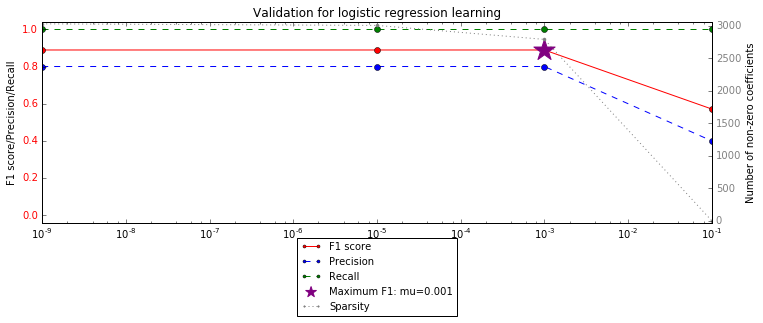

CPU times: user 8.71 s, sys: 135 ms, total: 8.84 s
Wall time: 4.8 s


<snorkel.snorkel.ModelLog instance at 0x17bc7f950>

In [104]:
import matplotlib
import numpy as np
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)

In [64]:
DDL.show_log()
idxs, gt = DDL.get_labeled_ground_truth(subset=DDL.holdout())
acc_feats = np.mean(DDL.get_predicted(subset=DDL.holdout()) == gt)
print "Full model accuracy: {:.3f}".format(acc_feats)

Full model accuracy: 0.000


/Users/bradenhancock/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  app.launch_new_instance()


Tune in next time for relation extraction!